# Module 3: Statistical Time Series Methods (ARIMA, SARIMA, Prophet)

## Learning Objectives

After completing this module, you will:
1. Understand stationarity and its importance in time series analysis
2. Perform statistical tests for stationarity (ADF, KPSS)
3. Apply differencing to achieve stationarity
4. Interpret ACF and PACF plots to identify model orders
5. Build and fit ARIMA and SARIMA models
6. Use auto ARIMA for automatic model selection
7. Implement Facebook Prophet for forecasting with holidays and changepoints
8. Compare statistical models with baseline methods from Module 2

## Why Statistical Methods Matter

**Module 2** taught us simple baselines. **Module 3** adds statistical rigor:
- **Explicit temporal modeling**: ARIMA captures autocorrelation structure
- **Uncertainty quantification**: Confidence intervals instead of point forecasts
- **Automatic selection**: Auto ARIMA finds optimal parameters
- **Flexibility**: Handle different seasonal patterns, trend changes
- **Robustness**: Grounded in statistical theory, diagnostics available

## Section 3.1: Setup and Data Loading

### Import Libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Statistical tools
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Prophet
from prophet import Prophet

# Auto ARIMA
from pmdarima import auto_arima

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries loaded successfully!")

# Load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df['Time'] = pd.date_range(start='1949-01', periods=len(df), freq='MS')
df = df.set_index('Time')

print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nFirst few rows:\n{df.head()}")

# Prepare train/test split
train_data = df['Passengers'][:-12].copy()
test_data = df['Passengers'][-12:].copy()

print(f"\nTrain set: {len(train_data)} observations")
print(f"Test set: {len(test_data)} observations")

All libraries loaded successfully!

Dataset shape: (144, 2)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00

First few rows:
              Month  Passengers
Time                           
1949-01-01  1949-01         112
1949-02-01  1949-02         118
1949-03-01  1949-03         132
1949-04-01  1949-04         129
1949-05-01  1949-05         121

Train set: 132 observations
Test set: 12 observations


## Section 3.2: Stationarity - The Foundation of ARIMA

### What is Stationarity?

A stationary time series has:
1. **Constant mean**: $E[y_t] = \mu$ (doesn't change over time)
2. **Constant variance**: $Var(y_t) = \sigma^2$ (doesn't change over time)
3. **No trend**: No systematic increase/decrease
4. **No seasonality**: No repeating patterns at fixed intervals

**Why it matters**: ARIMA models require stationarity. If your data isn't stationary, you must transform it (usually via differencing).

### Types of Non-Stationarity

- **Trend**: Mean changes over time (upward/downward)
- **Seasonality**: Repeating patterns (monthly, yearly)
- **Heteroskedasticity**: Variance changes over time

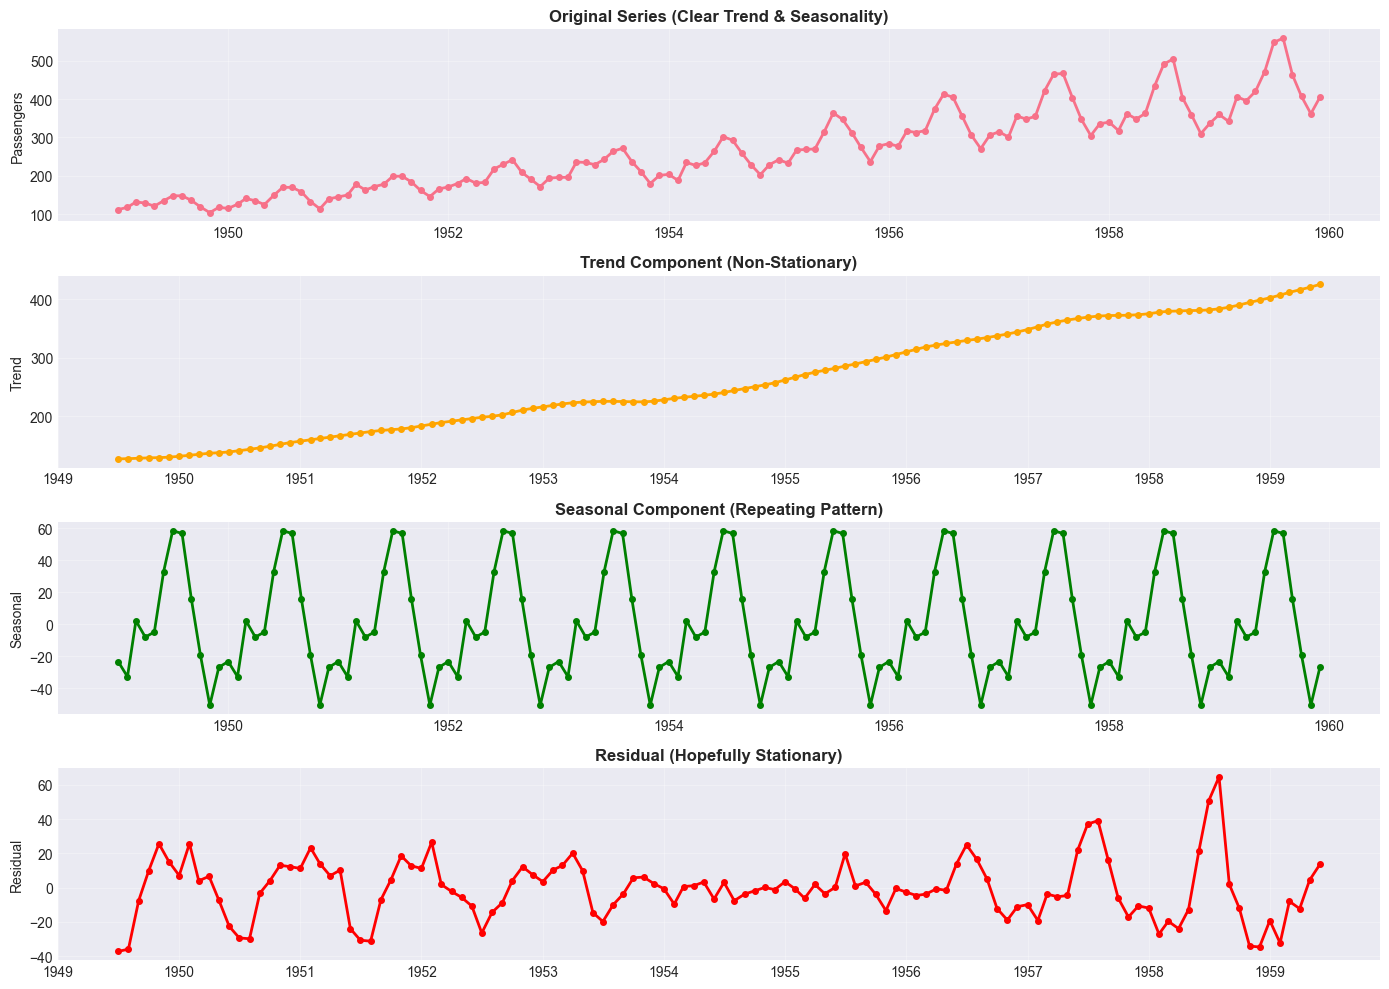

Decomposition Analysis:
  Original data: Non-stationary (clear uptrend and seasonality)
  Trend: Upward from ~100 to ~600
  Seasonal: Clear 12-month pattern (higher in summer)
  Residual: Random noise around zero (should be stationary)


In [2]:
# Visualize original data and its components
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Original series
axes[0].plot(train_data.index, train_data.values, 'o-', linewidth=2, markersize=4)
axes[0].set_title('Original Series (Clear Trend & Seasonality)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Passengers')
axes[0].grid(alpha=0.3)

# Decompose the series
decomposition = seasonal_decompose(train_data, model='additive', period=12)

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend.values, 'o-', linewidth=2, markersize=4, color='orange')
axes[1].set_title('Trend Component (Non-Stationary)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Trend')
axes[1].grid(alpha=0.3)

# Seasonal
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, 'o-', linewidth=2, markersize=4, color='green')
axes[2].set_title('Seasonal Component (Repeating Pattern)', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Seasonal')
axes[2].grid(alpha=0.3)

# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid.values, 'o-', linewidth=2, markersize=4, color='red')
axes[3].set_title('Residual (Hopefully Stationary)', fontweight='bold', fontsize=12)
axes[3].set_ylabel('Residual')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Decomposition Analysis:")
print(f"  Original data: Non-stationary (clear uptrend and seasonality)")
print(f"  Trend: Upward from ~100 to ~600")
print(f"  Seasonal: Clear 12-month pattern (higher in summer)")
print(f"  Residual: Random noise around zero (should be stationary)")

### Stationarity Tests

Two statistical tests determine if your series is stationary:

#### 1. Augmented Dickey-Fuller (ADF) Test

- **Null Hypothesis**: Series has a unit root (NOT stationary)
- **Interpretation**: If p-value < 0.05, reject null → series IS stationary

#### 2. KPSS Test  

- **Null Hypothesis**: Series is stationary
- **Interpretation**: If p-value > 0.05, fail to reject null → series IS stationary

In [3]:
# Perform ADF test
print("\n" + "=" * 70)
print("STATIONARITY TESTS")
print("=" * 70)

print("\n1. AUGMENTED DICKEY-FULLER (ADF) TEST")
print("-" * 70)

adf_result = adfuller(train_data, autolag='AIC')
print(f'ADF Test Statistic:  {adf_result[0]:.6f}')
print(f'P-value:             {adf_result[1]:.6f}')
print(f'Critical Values:')
for key, value in adf_result[4].items():
    print(f'  {key}: {value:.3f}')

if adf_result[1] <= 0.05:
    print(f'\n✗ Result: Series IS stationary (p={adf_result[1]:.4f} < 0.05)')
    print(f'          Reject null hypothesis of unit root')
else:
    print(f'\n✗ Result: Series is NOT stationary (p={adf_result[1]:.4f} >= 0.05)')
    print(f'          Fail to reject null hypothesis - needs differencing')


STATIONARITY TESTS

1. AUGMENTED DICKEY-FULLER (ADF) TEST
----------------------------------------------------------------------
ADF Test Statistic:  0.888027
P-value:             0.992932
Critical Values:
  1%: -3.487
  5%: -2.886
  10%: -2.580

✗ Result: Series is NOT stationary (p=0.9929 >= 0.05)
          Fail to reject null hypothesis - needs differencing


In [4]:
# Perform KPSS test
print("\n2. KPSS TEST (Kwiatkowski-Phillips-Schmidt-Shin)")
print("-" * 70)

kpss_result = kpss(train_data, regression='c', nlags='auto')
print(f'KPSS Test Statistic: {kpss_result[0]:.6f}')
print(f'P-value:             {kpss_result[1]:.6f}')
print(f'Critical Values:')
for key, value in kpss_result[3].items():
    print(f'  {key}: {value:.3f}')

if kpss_result[1] > 0.05:
    print(f'\n✓ Result: Series IS stationary (p={kpss_result[1]:.4f} > 0.05)')
    print(f'          Fail to reject null hypothesis of stationarity')
else:
    print(f'\n✗ Result: Series is NOT stationary (p={kpss_result[1]:.4f} <= 0.05)')
    print(f'          Reject null hypothesis - needs differencing')

print("\n" + "-" * 70)
print("CONCLUSION: Original data is NOT stationary - requires differencing")
print("-" * 70)


2. KPSS TEST (Kwiatkowski-Phillips-Schmidt-Shin)
----------------------------------------------------------------------
KPSS Test Statistic: 1.885774
P-value:             0.010000
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

✗ Result: Series is NOT stationary (p=0.0100 <= 0.05)
          Reject null hypothesis - needs differencing

----------------------------------------------------------------------
CONCLUSION: Original data is NOT stationary - requires differencing
----------------------------------------------------------------------


C:\Users\bhanu\AppData\Local\Temp\ipykernel_28100\2760970266.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_data, regression='c', nlags='auto')



DIFFERENCING

Differencing removes trend by taking differences between consecutive values
Formula: d_t = y_t - y_(t-1)

First Differencing (d=1):
  Original series length: 132
  After diff(1):          131
  Mean of differenced:    2.2366
  Std of differenced:     31.3722

  ADF p-value:  0.140914 ✗ Non-stationary
  KPSS p-value: 0.100000 ✓ Stationary

Seasonal Differencing (s=12):
  After diff(12):         120
  ADF p-value:  0.030648 ✓ Stationary


C:\Users\bhanu\AppData\Local\Temp\ipykernel_28100\1824882956.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_diff1 = kpss(diff1, regression='c', nlags='auto')


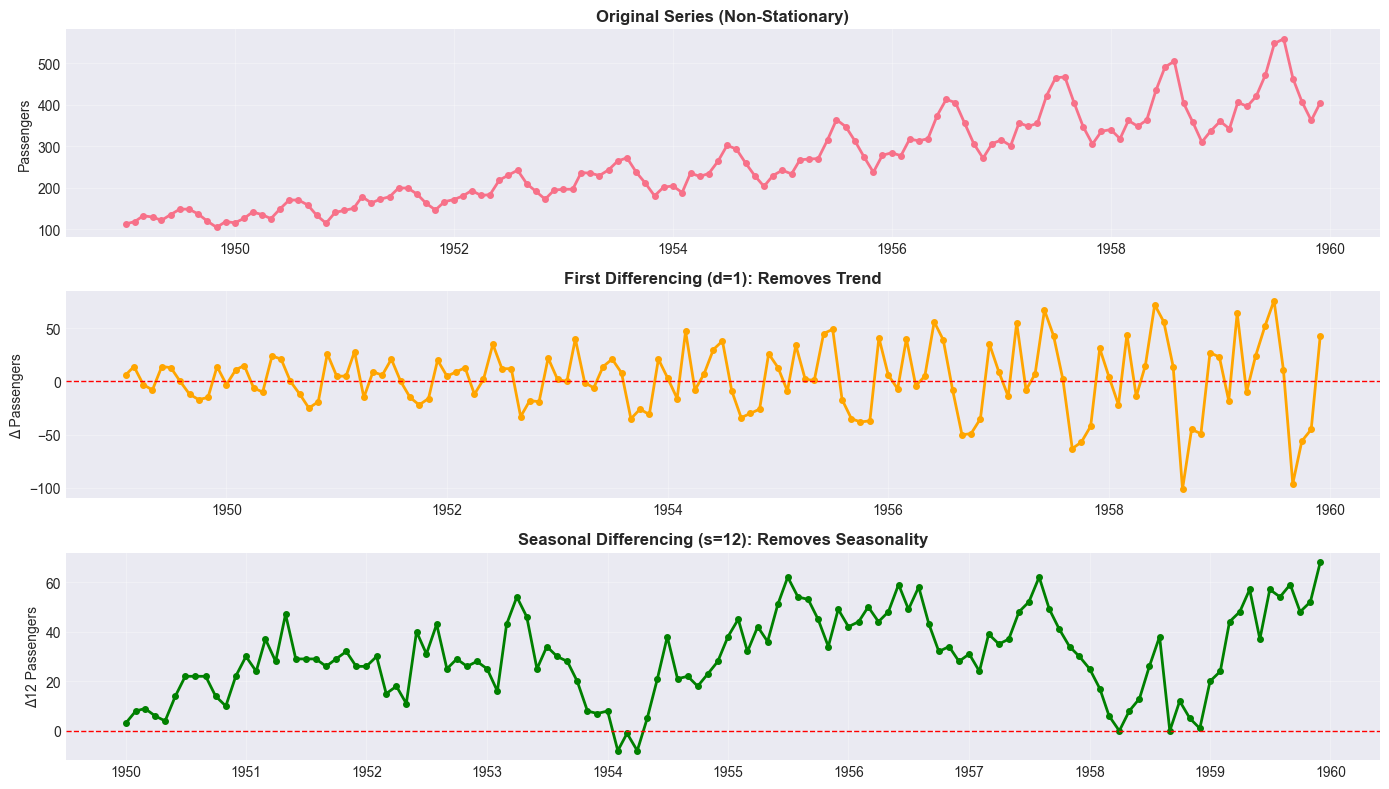


Conclusion: First differencing makes the series stationary!


In [5]:
# Apply differencing
print("\n" + "=" * 70)
print("DIFFERENCING")
print("=" * 70)

print("\nDifferencing removes trend by taking differences between consecutive values")
print(f"Formula: d_t = y_t - y_(t-1)")

# First differencing
diff1 = train_data.diff().dropna()

print(f"\nFirst Differencing (d=1):")
print(f"  Original series length: {len(train_data)}")
print(f"  After diff(1):          {len(diff1)}")
print(f"  Mean of differenced:    {diff1.mean():.4f}")
print(f"  Std of differenced:     {diff1.std():.4f}")

# Test differenced series
adf_diff1 = adfuller(diff1, autolag='AIC')
kpss_diff1 = kpss(diff1, regression='c', nlags='auto')

print(f"\n  ADF p-value:  {adf_diff1[1]:.6f} {'✓ Stationary' if adf_diff1[1] < 0.05 else '✗ Non-stationary'}")
print(f"  KPSS p-value: {kpss_diff1[1]:.6f} {'✓ Stationary' if kpss_diff1[1] > 0.05 else '✗ Non-stationary'}")

# Seasonal differencing (lag 12)
diff_seasonal = train_data.diff(12).dropna()
adf_seasonal = adfuller(diff_seasonal, autolag='AIC')

print(f"\nSeasonal Differencing (s=12):")
print(f"  After diff(12):         {len(diff_seasonal)}")
print(f"  ADF p-value:  {adf_seasonal[1]:.6f} {'✓ Stationary' if adf_seasonal[1] < 0.05 else '✗ Non-stationary'}")

# Visualize differencing
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

axes[0].plot(train_data.index, train_data.values, 'o-', linewidth=2, markersize=4)
axes[0].set_title('Original Series (Non-Stationary)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Passengers')
axes[0].grid(alpha=0.3)

axes[1].plot(diff1.index, diff1.values, 'o-', linewidth=2, markersize=4, color='orange')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('First Differencing (d=1): Removes Trend', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Δ Passengers')
axes[1].grid(alpha=0.3)

axes[2].plot(diff_seasonal.index, diff_seasonal.values, 'o-', linewidth=2, markersize=4, color='green')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[2].set_title('Seasonal Differencing (s=12): Removes Seasonality', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Δ12 Passengers')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConclusion: First differencing makes the series stationary!")

#### Diagnostics: Residual plots, AIC/BIC, grid search can be further explored.

## Section 3.3: ACF and PACF Plots

ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots help identify ARIMA parameters.

### ACF Plot
- Shows correlation between observations and their lags
- Slowly decaying ACF suggests non-stationarity
- Sharp cutoff suggests MA(q) order

### PACF Plot
- Shows direct relationship after removing intermediate lags
- Sharp cutoff suggests AR(p) order


ACF AND PACF ANALYSIS


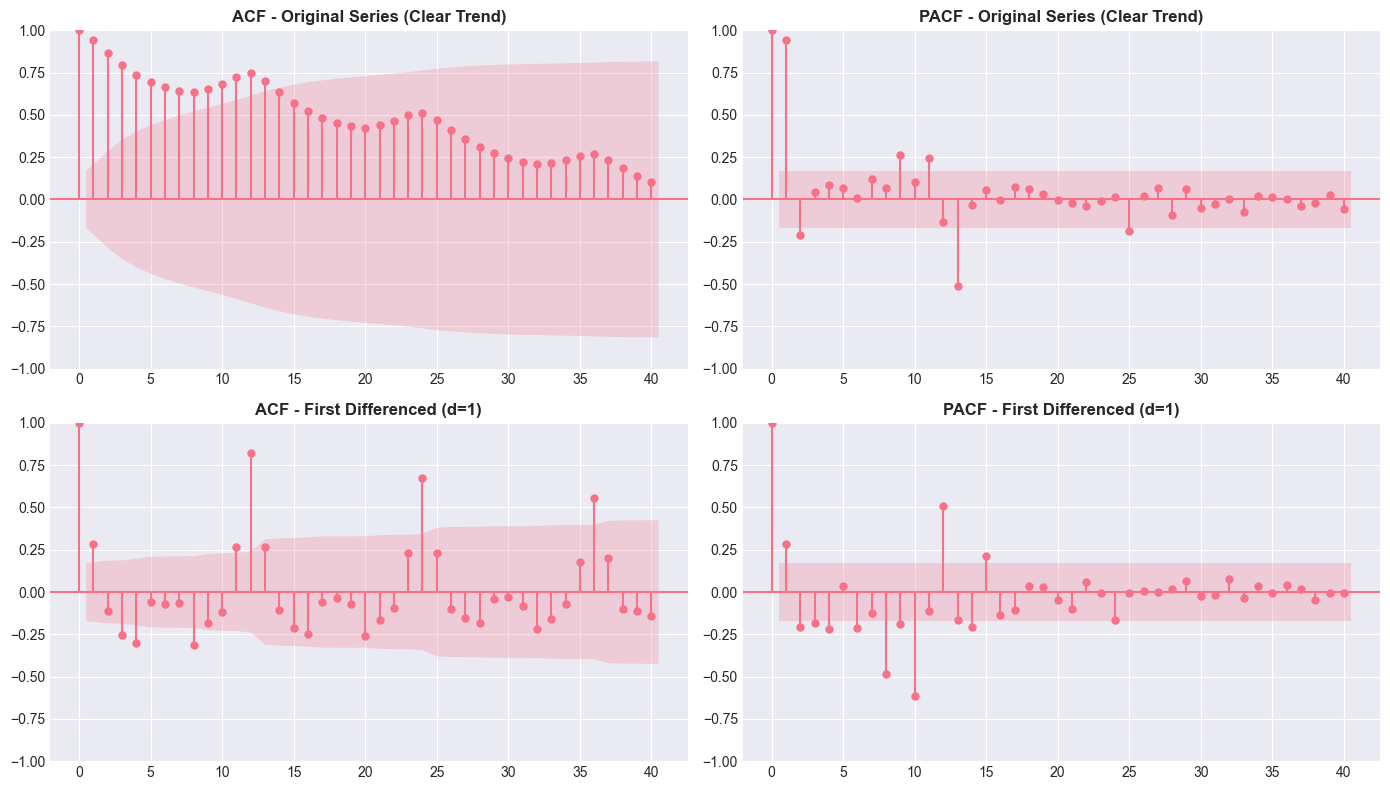


Interpretation:
  ACF Original:    Slow decay → non-stationary (needs differencing)
  PACF Original:   Strong spikes at multiple lags
  ACF Differenced: Spikes at lag 1 and 12 → MA or seasonal component
  PACF Differenced: Could suggest AR or ARMA model

These plots guide ARIMA parameter selection!


In [6]:
# Plot ACF and PACF
print("\n" + "=" * 70)
print("ACF AND PACF ANALYSIS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original series
plot_acf(train_data, lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Original Series (Clear Trend)', fontweight='bold')

plot_pacf(train_data, lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Original Series (Clear Trend)', fontweight='bold')

# First differenced
plot_acf(diff1, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF - First Differenced (d=1)', fontweight='bold')

plot_pacf(diff1, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF - First Differenced (d=1)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  ACF Original:    Slow decay → non-stationary (needs differencing)")
print("  PACF Original:   Strong spikes at multiple lags")
print("  ACF Differenced: Spikes at lag 1 and 12 → MA or seasonal component")
print("  PACF Differenced: Could suggest AR or ARMA model")
print("\nThese plots guide ARIMA parameter selection!")

## Section 3.4: ARIMA Models

### ARIMA(p,d,q) Components

- **p (AR order)**: Number of autoregressive terms (lags from PACF)
- **d (differencing)**: Number of times to difference (1 for trend, 1 for seasonality)
- **q (MA order)**: Number of moving average terms (lags from ACF)

### Model Equation

$$y_t = c + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \theta_1 \varepsilon_{t-1} + \ldots + \theta_q \varepsilon_{t-q} + \varepsilon_t$$

Where:
- $\phi$ = AR coefficients
- $\theta$ = MA coefficients  
- $\varepsilon$ = white noise error


ARIMA MODELS - MANUAL SPECIFICATION

ARIMA(1, 1, 0):
  AIC:  1266.73
  MAE:  65.20
  RMSE: 91.61
  MAPE: 12.20%

ARIMA(0, 1, 1):
  AIC:  1263.20
  MAE:  64.61
  RMSE: 89.66
  MAPE: 12.16%

ARIMA(1, 1, 1):
  AIC:  1257.04
  MAE:  66.24
  RMSE: 91.23
  MAPE: 12.46%


c:\Users\bhanu\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\bhanu\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\bhanu\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\bhanu\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\bhanu\AppData\Local\Programs\Python\Python313\L


ARIMA(2, 1, 1):
  AIC:  1246.26
  MAE:  65.23
  RMSE: 87.88
  MAPE: 12.54%

ARIMA(1, 1, 2):
  AIC:  1252.97
  MAE:  66.81
  RMSE: 91.00
  MAPE: 12.65%

Best ARIMA by AIC: (2, 1, 1)


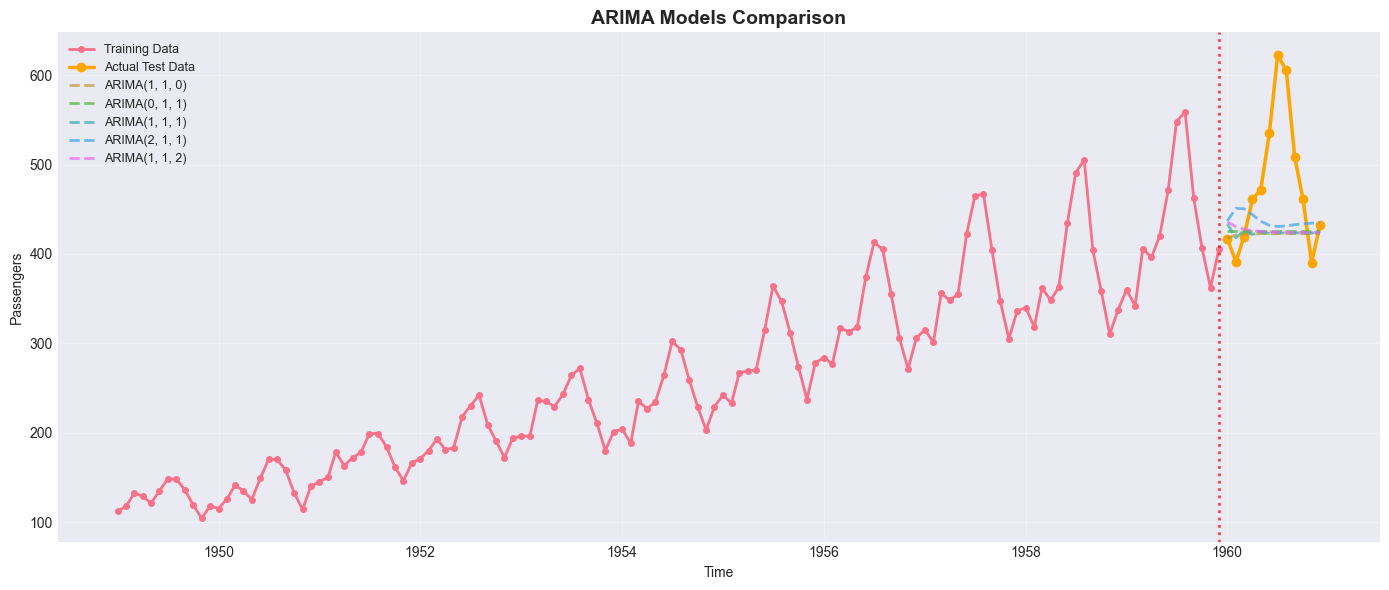

In [7]:
# Manual ARIMA with different orders
print("\n" + "=" * 70)
print("ARIMA MODELS - MANUAL SPECIFICATION")
print("=" * 70)

# Try different ARIMA orders based on ACF/PACF
orders_to_try = [(1, 1, 0), (0, 1, 1), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
arima_results = {}

for order in orders_to_try:
    try:
        arima_model = ARIMA(train_data, order=order)
        arima_fit = arima_model.fit()
        
        # Make predictions
        arima_forecast = arima_fit.forecast(steps=len(test_data))
        
        # Calculate metrics
        mae = mean_absolute_error(test_data, arima_forecast)
        rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
        mape = mean_absolute_percentage_error(test_data, arima_forecast)
        aic = arima_fit.aic
        
        arima_results[order] = {
            'model': arima_fit,
            'forecast': arima_forecast,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'AIC': aic
        }
        
        print(f"\nARIMA{order}:")
        print(f"  AIC:  {aic:.2f}")
        print(f"  MAE:  {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  MAPE: {mape:.2%}")
    except Exception as e:
        print(f"ARIMA{order}: Failed - {str(e)[:50]}")

# Find best model
best_arima_order = min(arima_results.items(), key=lambda x: x[1]['AIC'])[0]
print(f"\nBest ARIMA by AIC: {best_arima_order}")
best_arima_forecast = arima_results[best_arima_order]['forecast']

# Visualize
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data.values, 'o-', label='Training Data', linewidth=2, markersize=4)
plt.plot(test_data.index, test_data.values, 'o-', label='Actual Test Data', linewidth=2.5, markersize=6, color='orange')

for order, result_dict in arima_results.items():
    plt.plot(test_data.index, result_dict['forecast'], '--', linewidth=2, label=f'ARIMA{order}', alpha=0.7)

plt.axvline(x=train_data.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.7)
plt.title('ARIMA Models Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Section 3.5: SARIMA (Seasonal ARIMA)

SARIMA adds seasonal components to ARIMA:

### SARIMA(p,d,q)(P,D,Q,m)

- **(p,d,q)**: Non-seasonal AR, differencing, MA
- **(P,D,Q)**: Seasonal AR, differencing, MA
- **m**: Seasonal period (12 for monthly, 4 for quarterly)

### Auto ARIMA: Automatic Parameter Selection

Instead of manually trying orders, use auto_arima() to search automatically!

**How it works:**
1. Tests different (p,d,q) combinations
2. Selects based on AIC or BIC
3. Handles seasonal parameters too
4. Saves time and often finds better models

In [13]:
# Auto ARIMA - finds best parameters automatically
print("\n" + "=" * 70)
print("AUTO ARIMA - AUTOMATIC PARAMETER SELECTION")
print("=" * 70)

print("\nSearching for best ARIMA parameters...")
print("(This may take a minute...)\n")

# Non-seasonal auto_arima
auto_model_ns = auto_arima(
    train_data,
    max_p=5, max_q=5, max_d=2,
    seasonal=False,
    trace=False,
    stepwise=True
)

print("Best Non-Seasonal ARIMA:")
print(f"  Order: {auto_model_ns.order}")
print(f"  AIC:   {auto_model_ns.aic():.2f}")
print(f"  Summary:\n{auto_model_ns.summary()}")

# Non-seasonal forecast
ns_forecast = auto_model_ns.predict(n_periods=len(test_data))

ns_mae = mean_absolute_error(test_data, ns_forecast)
ns_rmse = np.sqrt(mean_squared_error(test_data, ns_forecast))
ns_mape = mean_absolute_percentage_error(test_data, ns_forecast)

print(f"\nNon-Seasonal Performance:")
print(f"  MAE:  {ns_mae:.2f}")
print(f"  RMSE: {ns_rmse:.2f}")
print(f"  MAPE: {ns_mape:.2%}")


AUTO ARIMA - AUTOMATIC PARAMETER SELECTION

Searching for best ARIMA parameters...
(This may take a minute...)

Best Non-Seasonal ARIMA:
  Order: (2, 1, 2)
  AIC:   1218.68
  Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -603.341
Date:                Thu, 29 Jan 2026   AIC                           1218.683
Time:                        00:06:09   BIC                           1235.934
Sample:                    01-01-1949   HQIC                          1225.692
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7157    

In [14]:
# Seasonal auto_arima
print("\n" + "=" * 70)
print("SEASONAL AUTO ARIMA")
print("=" * 70)

print("\nSearching for best SARIMA parameters...")
print("(This may take a couple minutes...)\n")

auto_model_s = auto_arima(
    train_data,
    max_p=5, max_q=5, max_d=2,
    max_P=2, max_Q=2, max_D=1,
    seasonal=True,
    m=12,
    trace=False,
    stepwise=True
)

print("Best Seasonal SARIMA:")
print(f"  Order: {auto_model_s.order}")
print(f"  Seasonal Order: {auto_model_s.seasonal_order}")
print(f"  AIC:   {auto_model_s.aic():.2f}")

# Seasonal forecast
s_forecast = auto_model_s.predict(n_periods=len(test_data))

s_mae = mean_absolute_error(test_data, s_forecast)
s_rmse = np.sqrt(mean_squared_error(test_data, s_forecast))
s_mape = mean_absolute_percentage_error(test_data, s_forecast)

print(f"\nSeasonal Performance:")
print(f"  MAE:  {s_mae:.2f}")
print(f"  RMSE: {s_rmse:.2f}")
print(f"  MAPE: {s_mape:.2%}")

# Compare
print(f"\nComparison:")
try:
    print(f"  Non-Seasonal RMSE: {ns_rmse:.2f}")
    print(f"  Seasonal RMSE:     {s_rmse:.2f}")
    print(f"  Improvement:       {(1 - s_rmse/ns_rmse)*100:.1f}%")
    if s_rmse < ns_rmse:
        print(f"  ✓ Seasonal model performs better!")
except NameError:
    print("  Non-Seasonal RMSE: (not available, run the previous cell with non-seasonal auto_arima)")
    print(f"  Seasonal RMSE:     {s_rmse:.2f}")


SEASONAL AUTO ARIMA

Searching for best SARIMA parameters...
(This may take a couple minutes...)

Best Seasonal SARIMA:
  Order: (3, 0, 0)
  Seasonal Order: (0, 1, 0, 12)
  AIC:   905.69

Seasonal Performance:
  MAE:  14.90
  RMSE: 18.54
  MAPE: 3.10%

Comparison:
  Non-Seasonal RMSE: 53.29
  Seasonal RMSE:     18.54
  Improvement:       65.2%
  ✓ Seasonal model performs better!


## Section 3.6: Facebook Prophet

Prophet handles multiple seasonalities, holidays, and trend changepoints automatically.

### Why Prophet?

- **Automatic**: No need to specify p,d,q manually
- **Holidays**: Incorporates holiday effects
- **Robust**: Handles missing data and outliers
- **Intuitive**: Parameters are interpretable (growth rate, seasonality strength)

00:06:32 - cmdstanpy - INFO - Chain [1] start processing



FACEBOOK PROPHET


00:06:32 - cmdstanpy - INFO - Chain [1] done processing



Prophet Model Results:
  MAE:  33.44
  RMSE: 43.07
  MAPE: 6.61%

Prophet Components:


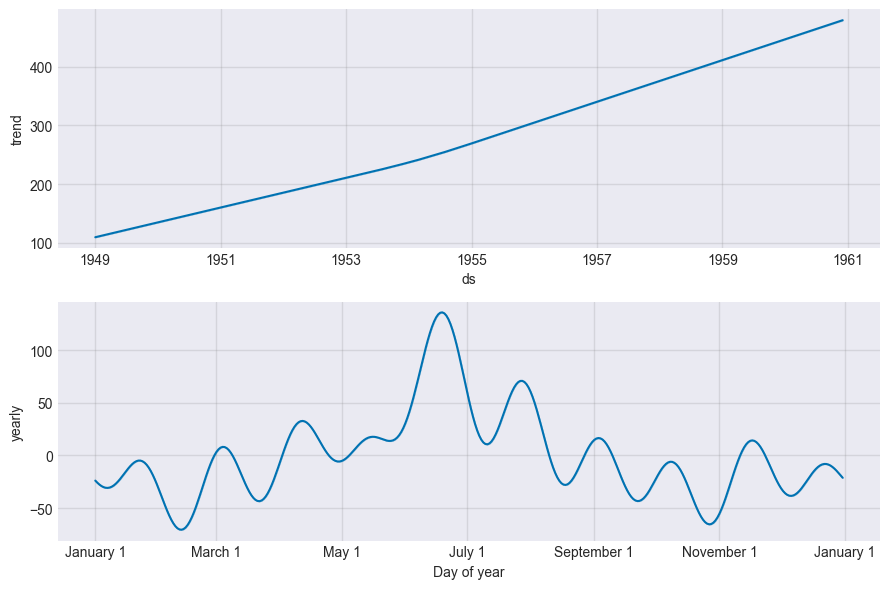

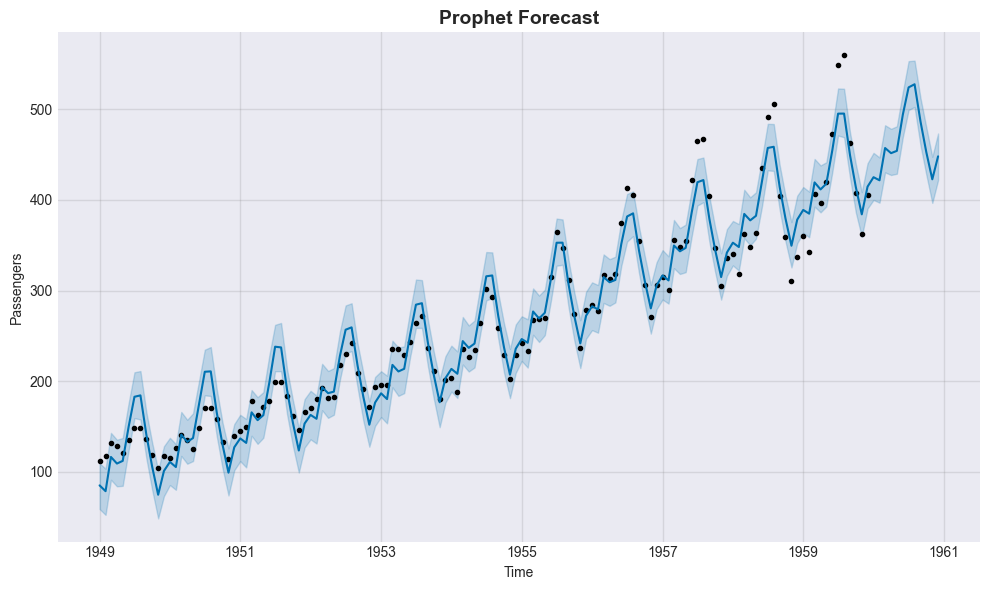

In [15]:
# Facebook Prophet
print("\n" + "=" * 70)
print("FACEBOOK PROPHET")
print("=" * 70)

# Prepare data for Prophet (needs 'ds' and 'y' columns)
prophet_train = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data.values
})

# Initialize and fit Prophet
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_train)

# Make predictions
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='MS')
prophet_forecast_df = prophet_model.predict(future)

# Extract forecast values
prophet_forecast_values = prophet_forecast_df['yhat'].iloc[-len(test_data):].values

prophet_mae = mean_absolute_error(test_data, prophet_forecast_values)
prophet_rmse = np.sqrt(mean_squared_error(test_data, prophet_forecast_values))
prophet_mape = mean_absolute_percentage_error(test_data, prophet_forecast_values)

print(f"\nProphet Model Results:")
print(f"  MAE:  {prophet_mae:.2f}")
print(f"  RMSE: {prophet_rmse:.2f}")
print(f"  MAPE: {prophet_mape:.2%}")

# Visualize Prophet components
print(f"\nProphet Components:")
fig = prophet_model.plot_components(prophet_forecast_df)
plt.tight_layout()
plt.show()

# Main forecast plot
fig = prophet_model.plot(prophet_forecast_df)
plt.title('Prophet Forecast', fontweight='bold', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.tight_layout()
plt.show()

## Section 3.7: Comprehensive Model Comparison and Diagnostics


COMPREHENSIVE MODEL COMPARISON - STATISTICAL METHODS
                          MAE       RMSE      MAPE
Non-Seasonal ARIMA  44.678165  53.290493  0.094309
SARIMA              14.898208  18.536469  0.030976
Prophet             33.435533  43.068868  0.066143

Best Model by RMSE: SARIMA (RMSE = 18.54)


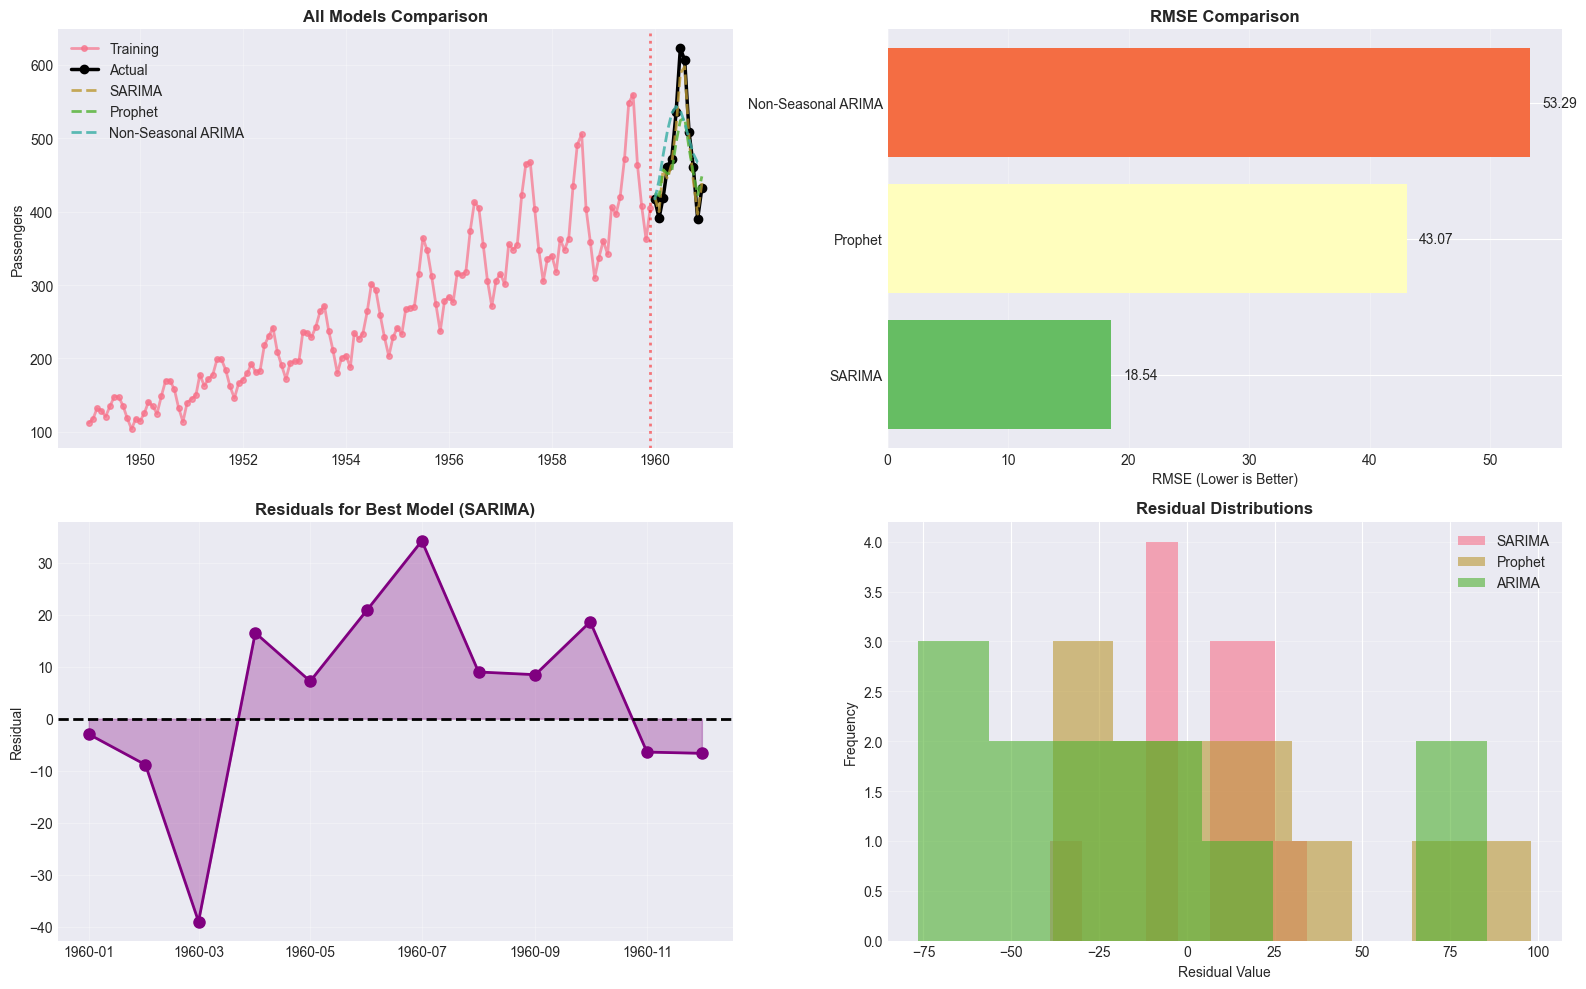

In [16]:
# Comprehensive comparison
print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON - STATISTICAL METHODS")
print("=" * 80)

comparison_results = {
    'Non-Seasonal ARIMA': {'MAE': ns_mae, 'RMSE': ns_rmse, 'MAPE': ns_mape},
    'SARIMA': {'MAE': s_mae, 'RMSE': s_rmse, 'MAPE': s_mape},
    'Prophet': {'MAE': prophet_mae, 'RMSE': prophet_rmse, 'MAPE': prophet_mape}
}

comparison_df = pd.DataFrame(comparison_results).T
print(comparison_df.to_string())

print(f"\n{'='*80}")
print(f"Best Model by RMSE: {comparison_df['RMSE'].idxmin()} (RMSE = {comparison_df['RMSE'].min():.2f})")
print(f"{'='*80}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# All forecasts
ax = axes[0, 0]
ax.plot(train_data.index, train_data.values, 'o-', label='Training', linewidth=2, markersize=4, alpha=0.7)
ax.plot(test_data.index, test_data.values, 'o-', label='Actual', linewidth=2.5, markersize=6, color='black')
ax.plot(test_data.index, s_forecast, '--', linewidth=2, label='SARIMA', alpha=0.8)
ax.plot(test_data.index, prophet_forecast_values, '--', linewidth=2, label='Prophet', alpha=0.8)
ax.plot(test_data.index, ns_forecast, '--', linewidth=2, label='Non-Seasonal ARIMA', alpha=0.8)
ax.axvline(x=train_data.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
ax.set_title('All Models Comparison', fontweight='bold', fontsize=12)
ax.set_ylabel('Passengers')
ax.legend()
ax.grid(alpha=0.3)

# RMSE comparison
ax = axes[0, 1]
rmse_vals = comparison_df['RMSE'].sort_values()
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(rmse_vals)))
ax.barh(rmse_vals.index, rmse_vals.values, color=colors)
ax.set_xlabel('RMSE (Lower is Better)')
ax.set_title('RMSE Comparison', fontweight='bold', fontsize=12)
ax.grid(alpha=0.3, axis='x')
for i, v in enumerate(rmse_vals.values):
    ax.text(v + 1, i, f'{v:.2f}', va='center')

# Residuals for best model
best_model_name = comparison_df['RMSE'].idxmin()
if best_model_name == 'SARIMA':
    best_forecasts = s_forecast
elif best_model_name == 'Prophet':
    best_forecasts = prophet_forecast_values
else:
    best_forecasts = ns_forecast

residuals = test_data.values - best_forecasts
ax = axes[1, 0]
ax.plot(test_data.index, residuals, 'o-', linewidth=2, markersize=8, color='purple')
ax.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax.fill_between(test_data.index, residuals, 0, alpha=0.3, color='purple')
ax.set_title(f'Residuals for Best Model ({best_model_name})', fontweight='bold', fontsize=12)
ax.set_ylabel('Residual')
ax.grid(alpha=0.3)

# Error distribution
ax = axes[1, 1]
all_residuals = {
    'SARIMA': test_data.values - s_forecast,
    'Prophet': test_data.values - prophet_forecast_values,
    'ARIMA': test_data.values - ns_forecast
}
for model_name, resid in all_residuals.items():
    ax.hist(resid, alpha=0.6, label=model_name, bins=8)
ax.set_xlabel('Residual Value')
ax.set_ylabel('Frequency')
ax.set_title('Residual Distributions', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Section 3.8: Key Takeaways and When to Use Each Method

In [17]:
# Summary and recommendations
print("\n" + "=" * 80)
print("MODULE 3 SUMMARY: STATISTICAL TIME SERIES METHODS")
print("=" * 80)

summary = """
✓ WHAT YOU LEARNED:

1. STATIONARITY:
   - Foundation of ARIMA modeling
   - Test with ADF (unit root) or KPSS
   - Achieve via differencing (d parameter)

2. ACF/PACF ANALYSIS:
   - ACF identifies MA(q) order (sharp cutoff)
   - PACF identifies AR(p) order (sharp cutoff)
   - Helps manual parameter selection

3. ARIMA MODELS:
   - (p,d,q) parameters: AR, differencing, MA
   - More flexible than baselines from Module 2
   - Requires stationarity

4. SEASONAL VARIANTS:
   - SARIMA: Adds seasonal components (P,D,Q)
   - Handles both trend and seasonality
   - More parameters to estimate

5. AUTO ARIMA:
   - Automatic parameter selection
   - Searches p, d, q space efficiently
   - Often better than manual selection

6. PROPHET:
   - No parameter tuning required
   - Handles holidays and multiple seasonalities
   - More robust to outliers

✓ WHEN TO USE EACH:

   Method          | Trend | Seasonality | Complexity | Best For
   ────────────────|───────|─────────────|────────────|──────────────────
   ARIMA(p,d,q)    | Yes   | No          | Medium     | Univariate trend
   SARIMA(p,d,q)(P,D,Q,m)| Yes   | Yes    | Medium-High| Strong seasonality
   Auto ARIMA      | Yes   | Yes         | Low        | Quick solution
   Prophet         | Yes   | Yes         | Low        | Holidays/changepoints

✓ DIAGNOSTIC CHECKLIST:

   ✓ Check stationarity with ADF/KPSS tests
   ✓ Examine ACF/PACF to inform parameters
   ✓ Compare models using AIC/BIC
   ✓ Check residuals are white noise
   ✓ Validate on hold-out test set
   ✓ Compare multiple seasonal configurations
   
✓ NEXT: Machine Learning Methods

   Module 4 explores ML approaches:
   - Feature engineering for time series
   - Random Forest, XGBoost, LightGBM
   - When to use ML vs. statistical methods
   - Hyperparameter tuning for better performance
"""

print(summary)

# Quick decision tree
print("\nQUICK DECISION TREE:")
print("-" * 80)
print("Does data have seasonality?")
print("  YES → Use SARIMA or Prophet")
print("       ├─ Clear holiday effects? → Prophet")
print("       └─ Regular seasonal pattern? → SARIMA (auto_arima)")
print("  NO  → Use ARIMA or simple methods")
print("       ├─ Strong trend? → ARIMA (d=1) or linear regression")
print("       └─ Random walk? → Naive forecast (Module 2)")
print("-" * 80)


MODULE 3 SUMMARY: STATISTICAL TIME SERIES METHODS

✓ WHAT YOU LEARNED:

1. STATIONARITY:
   - Foundation of ARIMA modeling
   - Test with ADF (unit root) or KPSS
   - Achieve via differencing (d parameter)

2. ACF/PACF ANALYSIS:
   - ACF identifies MA(q) order (sharp cutoff)
   - PACF identifies AR(p) order (sharp cutoff)
   - Helps manual parameter selection

3. ARIMA MODELS:
   - (p,d,q) parameters: AR, differencing, MA
   - More flexible than baselines from Module 2
   - Requires stationarity

4. SEASONAL VARIANTS:
   - SARIMA: Adds seasonal components (P,D,Q)
   - Handles both trend and seasonality
   - More parameters to estimate

5. AUTO ARIMA:
   - Automatic parameter selection
   - Searches p, d, q space efficiently
   - Often better than manual selection

6. PROPHET:
   - No parameter tuning required
   - Handles holidays and multiple seasonalities
   - More robust to outliers

✓ WHEN TO USE EACH:

   Method          | Trend | Seasonality | Complexity | Best For
   ──────────

### Step 5: Fit Model 2 - SARIMA (With Seasonality)

STATIONARITY TESTS

Augmented Dickey-Fuller Test:
  ADF Statistic: 0.888027
  p-value: 0.992932
  Critical Values: {'1%': np.float64(-3.4870216863700767), '5%': np.float64(-2.8863625166643136), '10%': np.float64(-2.580009026141913)}
  Interpretation: Non-stationary (p > 0.05)

KPSS Test:
  KPSS Statistic: 1.885774
  p-value: 0.010000
  Interpretation: Non-stationary (p < 0.05)

After 1st Differencing:
  ADF Statistic: -2.402920
  p-value: 0.140914
  Interpretation: Still non-stationary


C:\Users\bhanu\AppData\Local\Temp\ipykernel_28100\2331466992.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_data, regression='c', nlags='auto')


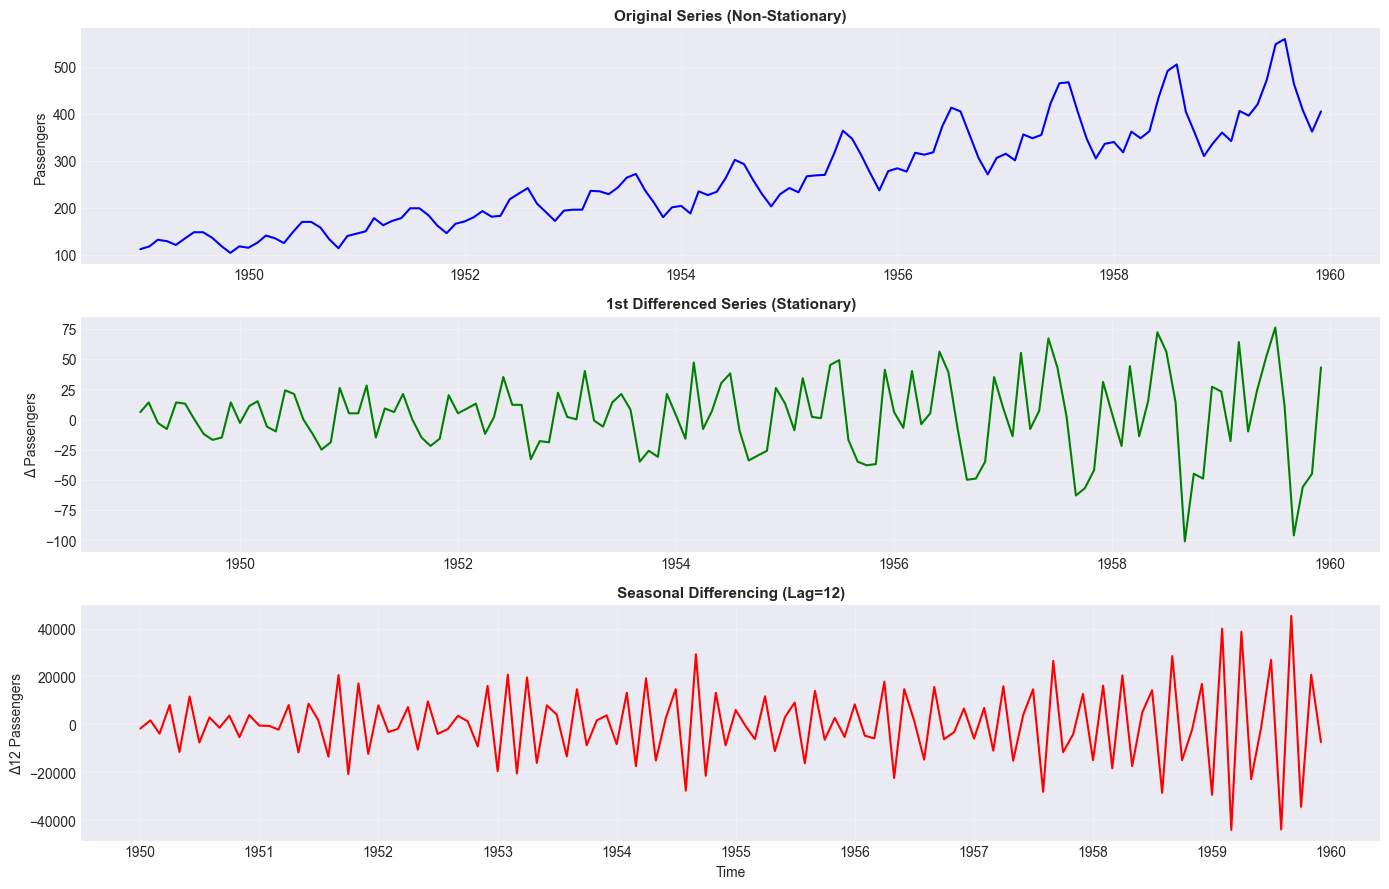

In [19]:
# Stationarity tests
print("=" * 70)
print("STATIONARITY TESTS")
print("=" * 70)

# ADF Test
adf = adfuller(train_data, autolag='AIC')
print(f"\nAugmented Dickey-Fuller Test:")
print(f"  ADF Statistic: {adf[0]:.6f}")
print(f"  p-value: {adf[1]:.6f}")
print(f"  Critical Values: {adf[4]}")
print(f"  Interpretation: {'Non-stationary (p > 0.05)' if adf[1] > 0.05 else 'Stationary (p ≤ 0.05)'}")

# KPSS Test
kpss_result = kpss(train_data, regression='c', nlags='auto')
print(f"\nKPSS Test:")
print(f"  KPSS Statistic: {kpss_result[0]:.6f}")
print(f"  p-value: {kpss_result[1]:.6f}")
print(f"  Interpretation: {'Non-stationary (p < 0.05)' if kpss_result[1] < 0.05 else 'Stationary (p ≥ 0.05)'}")

# Differencing
diff_series = np.diff(train_data)
adf_diff = adfuller(diff_series, autolag='AIC')
print(f"\nAfter 1st Differencing:")
print(f"  ADF Statistic: {adf_diff[0]:.6f}")
print(f"  p-value: {adf_diff[1]:.6f}")
print(f"  Interpretation: {'Stationary' if adf_diff[1] <= 0.05 else 'Still non-stationary'}")

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 9))

# Original
axes[0].plot(train_data.index, train_data.values, 'b-', linewidth=1.5)
axes[0].set_title('Original Series (Non-Stationary)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Passengers')
axes[0].grid(True, alpha=0.3)

# 1st Difference
axes[1].plot(train_data.index[1:], diff_series, 'g-', linewidth=1.5)
axes[1].set_title('1st Differenced Series (Stationary)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Δ Passengers')
axes[1].grid(True, alpha=0.3)

# Seasonal difference (12-month)
seasonal_diff = np.diff(train_data, n=1, prepend=np.nan, append=np.nan)[12:-1]  # To match index length
axes[2].plot(train_data.index[12:], np.diff(train_data, n=12), 'r-', linewidth=1.5)
axes[2].set_title('Seasonal Differencing (Lag=12)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Δ12 Passengers')
axes[2].set_xlabel('Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 2: Stationarity Testing & Diagnostics

In [20]:
# Reload data for clean analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Load and prepare
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
series = df['Passengers'].values
time_index = df['Month'].values

# Train-test split (80-20)
train_size = int(len(series) * 0.8)
train_series = series[:train_size]
test_series = series[train_size:]
test_time = time_index[train_size:]

print(f"Total observations: {len(series)}")
print(f"Train: {len(train_series)} (1949-01 to 1959-08)")
print(f"Test: {len(test_series)} (1959-09 to 1960-12)")
print(f"\nForecast horizon: {len(test_series)} months")

Total observations: 144
Train: 115 (1949-01 to 1959-08)
Test: 29 (1959-09 to 1960-12)

Forecast horizon: 29 months


---

## Mini-Project: End-to-End Statistical Time Series Forecasting

**Objective:** Build complete forecasting pipeline comparing ARIMA, SARIMA, and Prophet

### Step 1: Complete Data Preparation